In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn
import torch
import torchsummary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pickle
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

c:\Users\Jun Khai\miniconda3\envs\DeepLearning\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (None)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(


In [2]:

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
class DatasetWrapper(Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.y[idx]

[[0.5006536  0.53333336 0.5372549  ... 0.8705883  0.8928105  0.88366014]
 [0.6535948  0.55947715 0.49019608 ... 0.12418301 0.1503268  0.16470589]
 [0.45751634 0.45882353 0.46797386 ... 0.12156863 0.11764706 0.10980392]
 ...
 [0.48496735 0.45228758 0.45620918 ... 0.39869285 0.39084968 0.52679735]
 [0.43398693 0.44575164 0.6052287  ... 0.20653595 0.19215687 0.22222222]
 [0.04444445 0.05490196 0.06143792 ... 0.64836603 0.71503264 0.83267975]]
(966, 1850)
(322, 1850)
X_train shape: (966, 1, 50, 37)


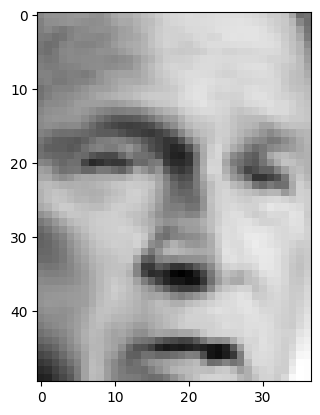

In [4]:
# from torch.nn import module
import torch
import cv2

# Split into a training set and a test set using a stratified k fold
x_tr, x_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25, random_state=42)# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# x_tr, x_ts, y_tr, y_ts = torch.from_numpy(x_tr), torch.from_numpy(x_ts), torch.from_numpy(y_tr), torch.from_numpy(y_ts)
print(x_tr)
#normalise
x_tr = x_tr / 255.0
x_ts = x_ts / 255.0
print(x_tr.shape)
print(x_ts.shape)
x_tr = x_tr.reshape(-1, 1, h, w)
x_ts = x_ts.reshape(-1, 1, h, w)

print("X_train shape:", x_tr.shape)
plt.imshow(x_tr[0, 0], cmap="gray")

In [30]:
import torch.nn as nn
import torch.nn.functional as F


class LFWCNN(nn.Module):
    def __init__(self):
        super(LFWCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3,stride=1),
            nn.ReLU()
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(26112, 100),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(100,7)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    def predict(self, x):
        o = self(x)
        l = torch.max(o, 1)[1]
        return l
    
    def score(self, x, y):
        '''
        Compute the model's accuracy on the given dataset.
        
        Parameters
        ----------
        x: input tensor
        y: ground truth values
        '''
        pred_cls = self.predict(x)
        true_cls = torch.max(y, 1)[1]
        return (pred_cls == true_cls).sum().float().item() / len(y)
        
    
# class LFWCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 64, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(64, 32, 3)
#         self.conv3 = nn.Conv2d(32, 8, 2)
#         self.fc1 = nn.Linear(120, 100)
#         self.fc2 = nn.Linear(100, 50)
#         self.fc3 = nn.Linear(50, 7)
#         self.sm = nn.Softmax(1)
#         # self.fc3 = nn.Linear(25, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         # x = self.sm(x)
#         return x


In [17]:
def train(net, x, y, x_ts, y_ts, lossfunc, lr=0.1, momentum=0, batch_size=600, nepochs=10, loop_prepend=""):
    device = next(net.parameters()).device # check what device the net parameters are on
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    # optimizer = optim.Adam(net.parameters(), lr=lr)
    
    accList = []
    testAccList = []
    net.train()

    # training loop
    dataloader = DataLoader(DatasetWrapper(x, y), batch_size=batch_size, shuffle=True)
    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        
        # Task: fill in your training code below and compute epoch_loss (the average loss on all batches in a epoch)
        epoch_loss = 0
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            # Get prediction from model and calculate loss
            x_batch.to(device)
            y_batch.to(device)
            y_pred = net(x_batch)
            loss = lossfunc(y_pred, y_batch)            
            epoch_loss += loss
            # Reset optimiser gradients
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            optimizer.step()
            # pass
        n_batches = len(dataloader)
        epoch_loss /= n_batches
        

        # evaluate network performance
        acc = test(net, x, y, batch_size=batch_size)
        testAcc = test(net, x_ts, y_ts, batch_size=batch_size)
        
        accList.append(acc.item())
        testAccList.append(testAcc.item())
        

        # show training progress
        loop.set_description(loop_prepend)
        loop.set_postfix(loss="%5.5f" % (epoch_loss),
                         train_acc="%.2f%%" % (100*acc))
    
    return accList, testAccList

# try running test(FashionMLP(), x_ts_mlp, y_ts_mlp, showerrors=True) to see what the code does
def test(net, x, y, batch_size=600, showerrors=False):
    with torch.no_grad(): # disable automatic gradient computation for efficiency
        device = next(net.parameters()).device

        pred_cls = []
        # make predictions on mini-batches  
        dataloader = DataLoader(DatasetWrapper(x), batch_size=batch_size, shuffle=False)
        for x_batch in dataloader:
            x_batch = x_batch.to(device)
            pred_cls.append(torch.max(net(x_batch), 1)[1].cpu())

        # compute accuracy
        pred_cls = torch.cat(pred_cls) # concat predictions on the mini-batches
        true_cls = torch.max(y, 1)[1].cpu()
        acc = (pred_cls == true_cls).sum().float() / len(y)

        # show errors if required
        if showerrors:
            idx_errors = (pred_cls != true_cls)

            x_errors = x[idx_errors][:10].cpu()
            y_pred = pred_cls[idx_errors][:10].cpu().numpy()
            y_true = true_cls[idx_errors][:10].cpu().numpy()

        return acc        


# def train(net, x, y, x_ts, y_ts, lossfunc, lr=0.1, momentum=0, batch_size=600, nepochs=10, loop_prepend=""):
#     device = next(net.parameters()).device # check what device the net parameters are on
#     optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
#     accList = []
#     testAccList = []

#     # training loop
#     dataloader = DataLoader(DatasetWrapper(x, y), batch_size=batch_size, shuffle=True)
#     loop = tqdm(range(nepochs), ncols=110)
#     for i in loop: # for each epoch
#         epoch_loss = 0
#         for (x_batch, y_batch) in dataloader: # for each mini-batch
#             # print("x_batch", x_batch.shape)
#             # print("y_batch", y_batch)
#             # Get prediction from model and calculate loss
#             x_batch.to(device)
#             y_batch.to(device)
#             y_pred = net(x_batch)
#             # print("ypred", y_pred[0][0])
#             # print(y_batch)
#             # print(y_pred)
#             loss = lossfunc(y_pred, y_batch)
#             print(loss)
#             # print(loss)
#             epoch_loss += loss.item()
#             # Reset optimiser gradients
#             optimizer.zero_grad()
#             # Backpropagation
#             loss.backward()
#             optimizer.step()
#         n_batches = len(dataloader)
#         epoch_loss /= n_batches
        

#         # evaluate network performance
#         acc = test(net, x, y, batch_size=batch_size)
#         testAcc = test(net, x_ts, y_ts, batch_size=batch_size)
        
#         accList.append(acc.item())
#         testAccList.append(testAcc.item())
        

#         # show training progress
#         loop.set_description(loop_prepend)
#         loop.set_postfix(loss="%5.5f" % (epoch_loss),
#                          train_acc="%.2f%%" % (100*acc))
    
#     return accList, testAccList

# def test(net, x, y, batch_size=600, showerrors=False):
#     with torch.no_grad(): # disable automatic gradient computation for efficiency
#         device = next(net.parameters()).device

#         pred_cls = []
#         # make predictions on mini-batches  
#         dataloader = DataLoader(DatasetWrapper(x), batch_size=batch_size, shuffle=False)
#         for x_batch in dataloader:
#             x_batch = x_batch.to(device)
#             pred_cls.append(torch.max(net(x_batch), 1)[1].cpu())

#         # compute accuracy
#         pred_cls = torch.cat(pred_cls) # concat predictions on the mini-batches
#         true_cls = torch.max(y, 1)[1].cpu()
#         acc = (pred_cls == true_cls).sum().float() / len(y)

#         # show errors if required
#         if showerrors:
#             idx_errors = (pred_cls != true_cls)

#             x_errors = x[idx_errors][:10].cpu()
#             y_pred = pred_cls[idx_errors][:10].cpu().numpy()
#             y_true = true_cls[idx_errors][:10].cpu().numpy()

#         return acc        

In [21]:
def int2onehot(y):
    onehot = torch.zeros(len(y), y.max()+1)
    onehot[torch.arange(len(y)), y] = 1
    return onehot.float()

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
x_tr, x_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25, random_state=42)
x_tr = x_tr.reshape(-1, 1, h, w)
x_ts = x_ts.reshape(-1, 1, h, w)
x_tr, x_ts, y_tr, y_ts = torch.tensor(x_tr).to(device), torch.tensor(x_ts).to(device), torch.tensor(int2onehot(y_tr)).to(device), torch.tensor(int2onehot(y_ts)).to(device)

C:\Users\Jun Khai\AppData\Local\Temp\ipykernel_26608\3927534834.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tr, x_ts, y_tr, y_ts = torch.tensor(x_tr).to(device), torch.tensor(x_ts).to(device), torch.tensor(int2onehot(y_tr)).to(device), torch.tensor(int2onehot(y_ts)).to(device)


In [31]:
net = LFWCNN().to(device)

lossfunc = nn.CrossEntropyLoss()
train(net, x_tr, y_tr, x_ts, y_ts, lossfunc, lr=0.01, momentum=0, batch_size=32, nepochs=500, loop_prepend="")
test(net, x_ts, y_ts, batch_size=32)

  0%|                                                                                 | 0/500 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x26112 and 28800x100)

In [29]:
for i, param in enumerate(net.parameters()):
    if i == 1:
        print(param.data)
        
print("Model No. of Parameters:", sum([param.nelement() for param in net.parameters()]))
print(net)

tensor([ 7.9677e-01, -1.4133e-01,  2.0224e-01, -5.6052e-01, -1.4909e-01,
         1.2156e-01, -1.3743e-01,  7.2361e-01, -2.7691e-01,  4.3781e-01,
        -2.3370e-01, -1.7290e-01,  1.3567e-01,  5.4978e-03, -9.9035e-02,
         1.6483e-01,  2.4506e-01, -1.8207e-01, -6.2783e-01, -1.9998e-03,
        -3.2500e-01, -1.8815e-01,  3.7839e-01, -2.4292e-01,  5.1796e-01,
        -3.6339e-01, -5.5861e-01, -1.3992e-01, -2.9804e-01, -5.7278e-02,
        -8.1512e-01, -3.5655e-04,  3.6810e-01,  4.6214e-01, -2.4316e-01,
        -1.0283e+00, -3.0585e-01, -2.9224e-01,  3.6787e-01, -4.1604e-02,
        -4.2684e-01, -2.0470e-01, -1.2756e-01,  5.2632e-02,  3.0202e-01,
         2.9621e-01, -5.4912e-01,  2.6923e-01, -3.2179e-01, -3.1334e-02,
        -2.7307e-01,  1.2755e-01,  1.5015e-01, -1.2153e-01,  6.1761e-01,
        -3.1481e-01, -2.6293e-01, -3.0579e-02, -1.2202e-01, -2.2435e-01,
        -4.9439e-02, -2.8698e-01, -1.4986e-01, -3.1821e-01], device='cuda:0')
Model No. of Parameters: 2899911
LFWCNN(
  (co

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
